# Downloading Data
To download data from yfinance, uncomment and run the following cell. This downloads the past 60 days of data from the first 100 tech stocks listed on https://companiesmarketcap.com/tech/largest-tech-companies-by-market-cap/ and saves it in a folder called `yf_data`. Make sure to run this notebook from the root directory.


In [1]:
# # load and store data
# !python3 atgym/atdata/data_loader.py

# Imports
The library atgym provides a data loader class and an OpenAI-stle trading environment. We use these to train and evaluate strategies.

A short description of the strategies:

Conventional
- SMAStrategy: uses simple moving average as momentum indicator that can trigger buy/sell actions
- WMAStrategy: like SMAStrategy, but uses a linearly weighted moving average
- EMAStrategy: like SMAStrategy, but uses an exponentially weighted moving average
- EngulfingStrategy: goal is to detect and capitalize on trend reversals
- RSIStrategy: uses relative strength index to determine overbought/underbought conditions

Reinforcement-Learning-Based
- DQNStrategy: periodically updates a neural network that approximates the target network
- A2CStrategy: uses an advantage actor-critic model where the actor executes the policy and the critic evaluates the taken action
- PPO: proximal-policy optimization, can also use actor-critic model but is distinct for its use of ratio clipping that prevents large, detrimental gradient updates to the network

In [1]:
from atgym.atdata import TradingDataLoader
from atgym.atsim import TradingEnv
from atgym.atstrategies import (
    SMAStrategy,
    WMAStrategy,
    EMAStrategy,
    EngulfingStrategy,
    RSIStrategy,
    A2CStrategy,
    DQNStrategy,
    PPOStrategy
)

# Loading Data

In [2]:
# load data using the TradingDataLoader class
tdl = TradingDataLoader()
tdl.load_data()

# split data into train and test
train_data, test_data = tdl.train_test_split(train_size=None, test_size=0.2,
                         split_by_time=True, random_state=42)

In [3]:
train_env = TradingEnv(train_data, trading_cost_pct=0.0)
test_env = TradingEnv(test_data, trading_cost_pct=0.0)

In [4]:
obs_shape = train_env.reset().shape
print(obs_shape)

(20, 4)


# Conventional Strategies

## Moving-Average-Based Strategies

In [6]:
import numpy as np

def visualize_strategy(strategy):
    np.random.seed(44)

    state = test_env.reset()
    rewards = []
    while True:
        action = strategy.predict(state)
        state, reward, done, info = test_env.step(action)

        rewards.append(reward)
        if done:
            test_env.render()
            break
    print("total reward: ", sum(rewards))

In [7]:
sma = SMAStrategy(obs_shape=obs_shape)
wma = WMAStrategy(obs_shape=obs_shape)
ema = EMAStrategy(obs_shape=obs_shape)

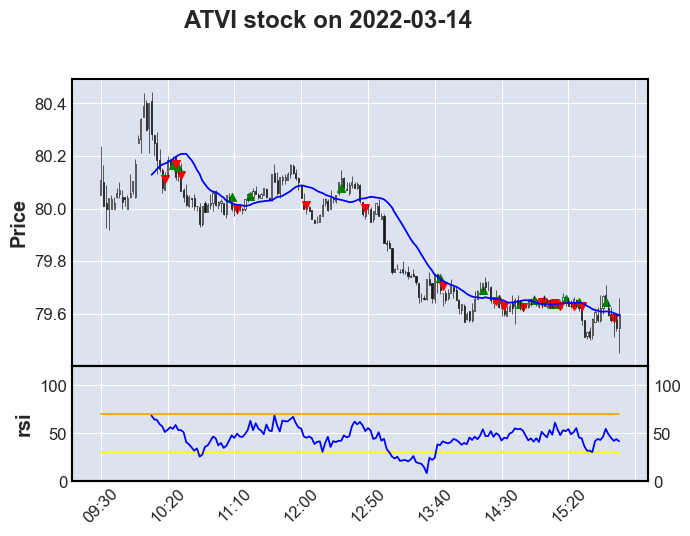

total reward:  0.0015121068622204747


In [8]:
visualize_strategy(sma)

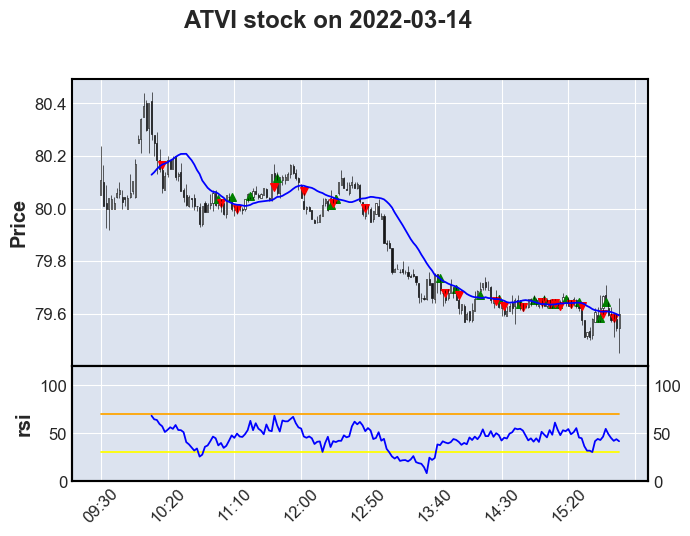

total reward:  0.003074869852351836


In [9]:
visualize_strategy(wma)

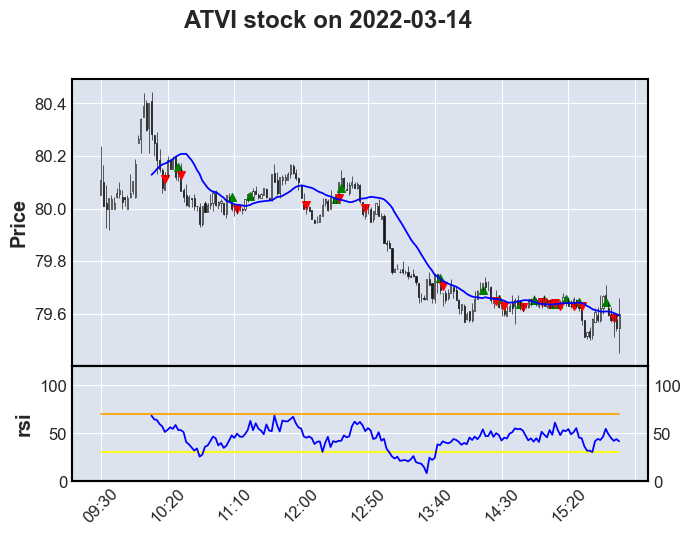

total reward:  0.0015120592082898954


In [10]:
visualize_strategy(ema)

# Engulfing Strategy

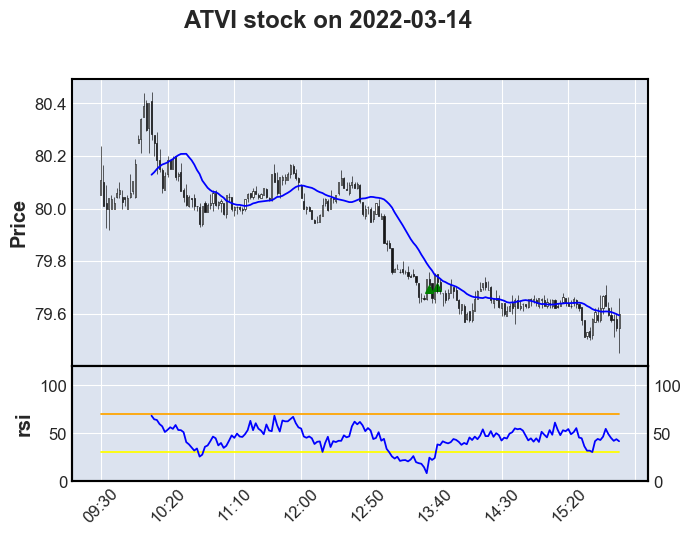

total reward:  -0.0031230956298105017


In [11]:
engulf = EngulfingStrategy(obs_shape=obs_shape)
visualize_strategy(engulf)

## Relative Strength Index Strategy

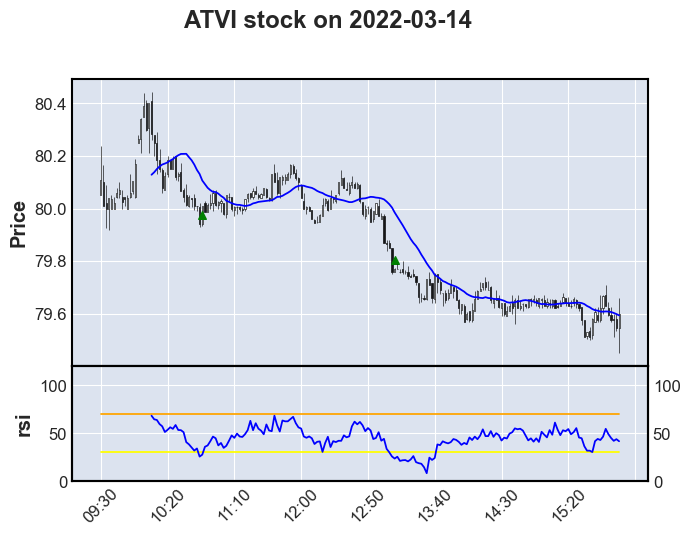

total reward:  -0.007916985709730096


In [12]:
rsi = RSIStrategy(obs_shape=obs_shape)
visualize_strategy(rsi)

## Performance of Implementations of Conventional Strategies

In [72]:
sma_error = test_env.evaluate(sma, normalized=True)

evaluating sma_strategy_0...
        SQ: 0.006372395453979866
     MPNGF
      SNOW: -0.002648134340758409
      SNPS: 0.0001452786102330942
        JD: -0.008542142801247469
      BABA: -0.009785631730611422
      CRWD: -0.0063319219651671865
      CDNS: 0.0026610167819846784
       CRM: -0.004201546794883752
     TCEHY: -0.002132479143834552
       ADP: 0.0004239815643187206
      AVGO: -0.002670488924555625
       IBM: 0.0064381331690676795
       GPN: -0.00026702848144449787
        SE: 0.00958163203827204
       NOW: -0.01771109737947074
      ADSK: -0.003463302765357279
      INTU: -0.004730011842422666
    CSU.TO
 005930.KS: -0.010937439065946816
      ATVI: -0.0012184372581085141
    IFX.DE: -0.0017016417277178435
      NXPI: -0.008542662022677209
      CSCO: 0.0028770344723018835
      MCHP: -0.002590766682043888
      EQIX: -0.0028966847022291096
       ADI: -0.0067147050230873155
   2454.TW: 0.007428744963056566
      INTC: -0.00396675128050189
 035420.KS: -3.185389034767357

In [73]:
wma_error = test_env.evaluate(wma, normalized=True, verbose=False)

In [74]:
ema_error = test_env.evaluate(ema, normalized=True, verbose=False)

In [75]:
print(sma_error, wma_error, ema_error)

-0.004660632360880294 -0.0050770696176938804 -0.004679750618269039


In [77]:
engulf_error = test_env.evaluate(engulf, normalized=True, verbose=False)

In [78]:
rsi_error = test_env.evaluate(rsi, normalized=True, verbose=False)

/Users/victorli/Documents/Code/Python Projects/atgym/atgym/atutils/compute_indicators.py:47: RuntimeWarning: invalid value encountered in double_scalars
  ratio = avg_gain / avg_loss


In [79]:
print(engulf_error, rsi_error)

-0.0006599791873665323 -0.0041040643877393755


### Summary
On the whole, the implementations of the conventional algorithms did not perform very well. In each case, while the normalized loss was minimal, these were not winning strategies. This may be due to the fact that they are often over-used, do not take into account anything other than the prices of the look-back period, and too simple of an implementation. It seems like the engulfing strategy did the best in terms of minimizing losses; however, this may be due to the fact that it is triggered less often than the other algorithms.

# Reinforcement Learning Strategies

## DQN
Deep Q-Network, which approximates a value function with a neural network and selects actions based on what maximizes the sum of reward and value of the next state. Used to achieve human-level performance on Atari games and is the basis for many other current RL algorithms.

In [38]:
dqn = DQNStrategy(obs_shape=obs_shape, env=train_env)
a2c = A2CStrategy(obs_shape=obs_shape, env=train_env)
ppo = PPOStrategy(obs_shape=obs_shape, env=train_env)

In [39]:
# train for 500000 timesteps
print_freq = int(5e4)

# train strategies, periodically testing the reward on test set
def test_env_returns(strategy):
    norm_returns = []
    for i in range(10):
        print(f'training {str(print_freq * i).zfill(6)} to {str(print_freq * (i+1)).zfill(6)}')
        strategy.train(print_freq)
        norm_return = test_env.evaluate(strategy, normalized=True, verbose=False)
        print("   normalized returns: ", norm_return)
        norm_returns.append(norm_return)
    return norm_returns

In [ ]:
print('--- dqn ---')
dqn_returns = test_env_returns(dqn)
print('--- a2c ---')
a2c_returns = test_env_returns(a2c)
print('--- ppo ---')
ppo_returns = test_env_returns(ppo)

--- dqn ---
training 000000 to 050000
   normalized returns:  0.4467630226268987
training 050000 to 100000
   normalized returns:  0.44353980690342354
training 100000 to 150000
   normalized returns:  0.44710166088287256
training 150000 to 200000
   normalized returns:  0.44157638971525126
training 200000 to 250000
   normalized returns:  0.43877549130053795
training 250000 to 300000
   normalized returns:  0.4453796688210326
training 300000 to 350000
   normalized returns:  0.44245810890455045
training 350000 to 400000
   normalized returns:  0.44499343287720444
training 400000 to 450000
   normalized returns:  0.4468029104695794
training 450000 to 500000
   normalized returns:  0.44634999722820884
--- a2c ---
training 000000 to 050000
   normalized returns:  -0.4347117362409125
training 050000 to 100000
   normalized returns:  -0.46827252868616454
training 100000 to 150000
   normalized returns:  -0.4684290257368183
training 150000 to 200000


In [ ]:
import matplotlib.pyplot as plt
steps = [50000 * (i+1) for i in range(10)]

plt.title('RL algorithm performances')
plt.xlabel('steps')
plt.ylabel('returns')
plt.plot(steps, dqn_returns, label='dqn_returns')
plt.plot(steps, a2c_returns, label='a2c_returns')
plt.plot(steps, ppo_returns, label='ppo_returns')